In [7]:
import os
import tensorflow as tf
from stackn import stackn
from fedn.utils.kerashelper import KerasHelper
from client.models.autocoder import create_seed_model

import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

In [14]:
def fedn_create_model(model_id):
    path_to_model_weights = '/home/jovyan/work/minio-vol/fedn-models/{}'.format(model_id)
    helper = KerasHelper()
    weights = helper.load_model(path_to_model_weights)
    model = create_seed_model()
    model.set_weights(weights)
    tf.saved_model.save(model, 'models/2/')
    stackn.create_object('fedn-fraud', release_type="minor")

In [15]:
fedn_create_model("407a9d49-3559-409c-9d0c-431a201c3eda")

INFO:tensorflow:Assets written to: models/2/assets


05/21/2021 02:12:10 PM [builder_impl.py:774] Assets written to: models/2/assets


Released model: fedn-fraud, release_type: minor


Importing data (need to be done before and instead imported here)

In [8]:
import pandas as pd

df = pd.read_csv("data.csv") #unzip and read in data downloaded to the local directory
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column
test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [9]:
len(test_x)

56962

In [20]:
test_x_predictions = autoencoder.predict(test_x)

mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})


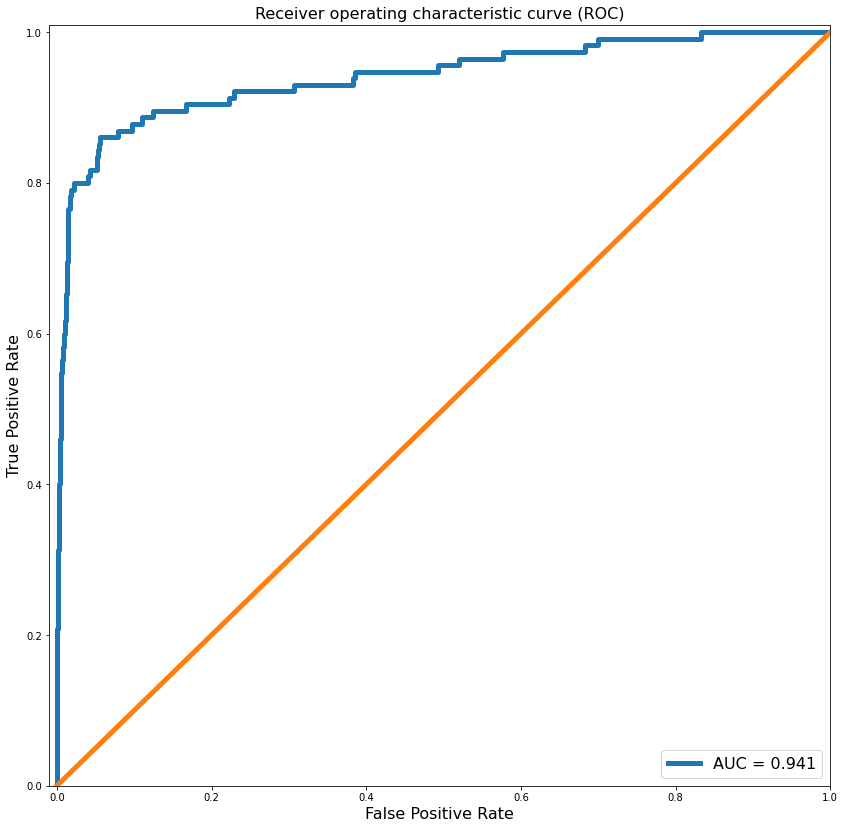

In [25]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
fontsize = 16
f, ax = plt.subplots(1,1,figsize=(14,14))
ax.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
ax.plot([0,1],[0,1], linewidth=5)

ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.legend(loc='lower right',fontsize=fontsize)
ax.set_title('Receiver operating characteristic curve (ROC)',fontsize=fontsize)
ax.set_ylabel('True Positive Rate',fontsize=fontsize)
ax.set_xlabel('False Positive Rate',fontsize=fontsize)
plt.show()

# $Precision = \frac{tp}{(tp + fp)} = \frac{tp}{predicted true}$
# $Recall = \frac{tp}{(tp + fn)} = \frac{tp}{total true}$

## Case
The prior probability (frequency) of fraud transactions is 0.17%, the use case of this model is to be able to flag possible fraud transactions with a high recall without loosing to much precision.  Depending of the buisness model different thresholds values can be used to flag a transaction. It is a tradeoff between chosing a high treshold value to have a high recall without lossing to much precision. We plot the tradeoff  

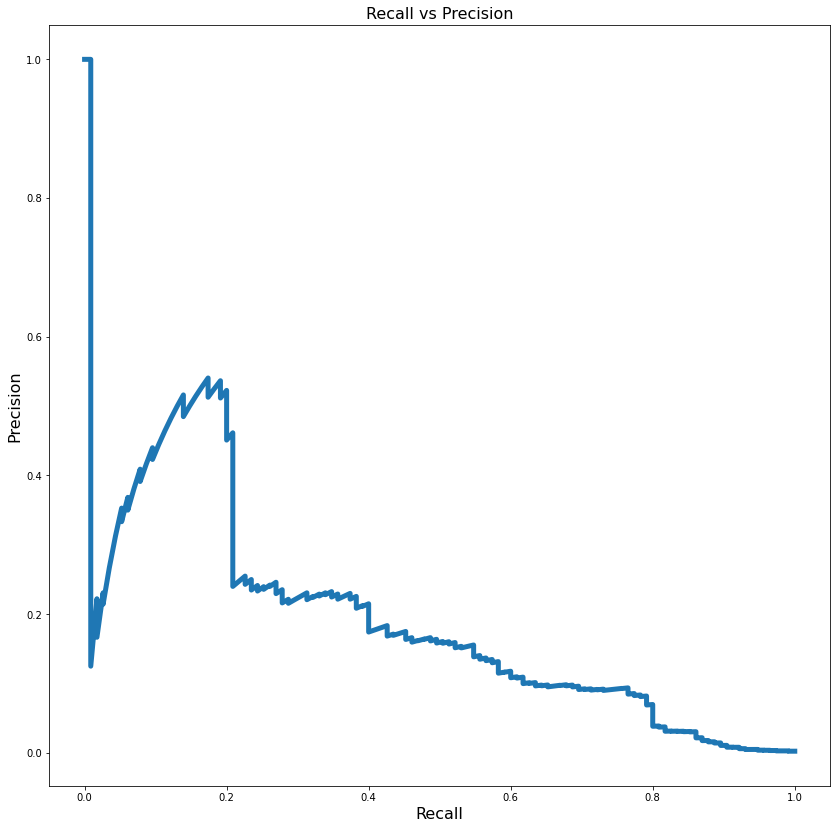

In [45]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
f, ax = plt.subplots(1,1,figsize=(14,14))

ax.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
ax.set_title('Recall vs Precision',fontsize=fontsize)
ax.set_xlabel('Recall',fontsize=fontsize)
ax.set_ylabel('Precision',fontsize=fontsize)
plt.show()

We can also plot 

0.6
rec point:  46791


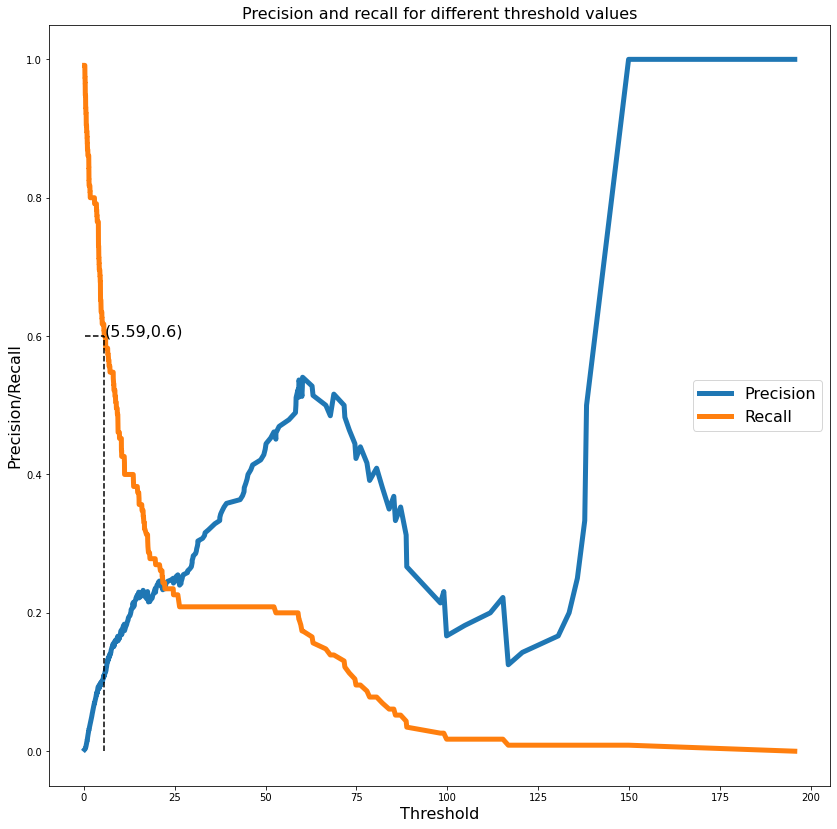

In [125]:
f, ax = plt.subplots(1,1,figsize=(14,14))

desired_recall_value = 0.6
recall_point = np.argmin(abs(recall_rt[1:]-desired_recall_value))
print(recall_rt[recall_point+1])
print("rec point: ", recall_point)
points = recall_point*2
ax.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
ax.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
ax.plot([threshold_rt[recall_point+1], threshold_rt[recall_point+1]], [0, recall_rt[recall_point+1]], c='black', ls='--')
ax.plot([threshold_rt[0], threshold_rt[recall_point]], [recall_rt[recall_point+1], recall_rt[recall_point+1]], c='black', ls='--')
ax.text(threshold_rt[recall_point], recall_rt[recall_point+1],
        '(' + str(round(threshold_rt[recall_point],2)) + "," + str(round(recall_rt[recall_point+1],2)) + ")", fontsize=fontsize)
#ax.semilogx()
ax.set_title('Precision and recall for different threshold values',fontsize=fontsize)
ax.set_xlabel('Threshold',fontsize=fontsize)
ax.set_ylabel('Precision/Recall',fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()

 Wrapping the autoencoder into a fraud flagging function.

In [127]:
def flag_wrapper_function(x, threshold=5):
    # returns true if transaction is flagged
    enc = autoencoder.predict(x)
    mse = np.mean((enc-x)**2,-1)
    return mse > threshold

Let say we want a recall value = 0.6 that corresponds to a threshold value of 5.59.

In [128]:
test_predicitons = flag_wrapper_function(test_x,5.59)

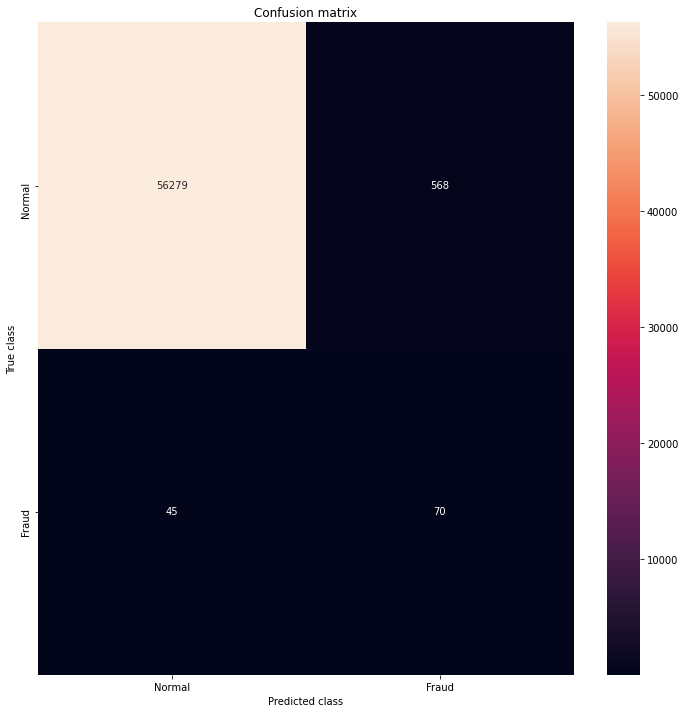

In [129]:
conf_matrix = confusion_matrix(test_y, np.int32(test_predicitons))

plt.figure(figsize=(12, 12))
LABELS = ["Normal","Fraud"]
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [134]:
recall = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0])
precision =  conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1])
print("recall: ", np.round(recall,3), ", precision: ", np.round(precision,3))
print("nr. of flagged transactions: ", conf_matrix[0,1] +conf_matrix[1,1], "/", np.sum(conf_matrix))

recall:  0.609 , precision:  0.11
nr. of flagged transactions:  638 / 56962


## Conclusions
The flag function capture 60.9% of all the fraud transactions. 11.5% Of the flagged transaction was true frauds. 1.1% of the transaction was flagged.